In [1]:
%matplotlib inline
import concurrent.futures
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from rethinking import LM, MAP, PI, coeftab, compare, compare_plot, ensemble

plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["lines.linewidth"] = 1
pyro.set_rng_seed(0)

#### Code 6.1

In [2]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster",
            "sapiens"]
brainvolcc = torch.tensor([438., 452, 612, 521, 752, 871, 1350])
masskg = torch.tensor([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})
d_mass = masskg
d_brain = brainvolcc

#### Code 6.2

In [3]:
m6_1 = LM("m6.1", mass=d_mass, brain=d_brain)
m6_1.fit(lr=3);

#### Code 6.3

In [4]:
resid = d_brain - (m6_1.coef()["intercept"] + m6_1.coef()["mass"] * d_mass)
1 - resid.var() / d_brain.var()

tensor(0.4902)

#### Code 6.4

In [5]:
m6_2 = LM("m6.2", mass=d_mass, mass2=(d_mass ** 2), brain=d_brain)
m6_2.fit(lr=3);

#### Code 6.5

In [6]:
m6_3 = LM("m6.3", mass=d_mass, mass2=(d_mass ** 2), mass3=(d_mass ** 3), brain=d_brain)
m6_3.fit(lr=3);
m6_4 = LM("m6.4", mass=d_mass, mass2=(d_mass ** 2), mass3=(d_mass ** 3), mass4=(d_mass ** 4),
          brain=d_brain)
m6_4.fit(lr=3);
m6_5 = LM("m6.5", mass=d_mass, mass2=(d_mass ** 2), mass3=(d_mass ** 3), mass4=(d_mass ** 4),
          mass5=(d_mass ** 5), brain=d_brain)
m6_5.fit(lr=3);
m6_6 = LM("m6.6", mass=d_mass, mass2=(d_mass ** 2), mass3=(d_mass ** 3), mass4=(d_mass ** 3),
          mass5=(d_mass ** 3), mass6=(d_mass ** 3), brain=d_brain)
m6_6.fit(lr=3);

#### Code 6.6

In [7]:
m6_7 = LM("m6.7", intercept=1, brain=d_brain)
m6_7.fit(lr=3);

#### Code 6.7

In [8]:
i = 0
d_new = d.drop(index=i)

#### Code 6.8

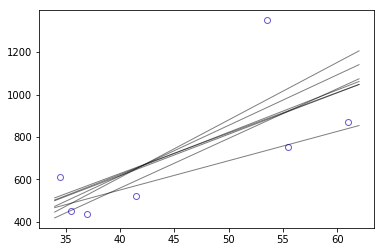

In [9]:
plt.plot("mass", "brain", "o", data=d, c="slateblue", fillstyle="none")
for i in range(d.shape[0]):
    d_new = d.drop(index=i)
    d_new_mass = torch.tensor(d_new["mass"].values, dtype=torch.float)
    d_new_brain = torch.tensor(d_new["brain"].values, dtype=torch.float)
    m0 = LM("m0_{}".format(i), mass=d_new_mass, brain=d_new_brain)
    m0.fit(lr=3)
    x = torch.linspace(34, 62, 101)
    plt.plot(x.tolist(), (m0.coef()["intercept"] + m0.coef()["mass"] * x).tolist(),
             c="k", alpha=0.5);

#### Code 6.9

In [10]:
p = torch.tensor([0.3, 0.7])
- (p * p.log()).sum()

tensor(0.6109)

#### Code 6.10

In [11]:
# fit model with lm
m6_1 = LM("m6.1_1", mass=d_mass, brain=d_brain)
m6_1.fit(lr=3);

# compute deviance by cheating
(-2) * m6_1.log_lik()

tensor(-94.9250)

#### Code 6.11

In [12]:
# standardize the mass before fitting
d_mass_s = d_mass - d_mass.mean() / d_mass.std()

def m6_8_model(mass, brain):
    a = pyro.param("m6.8_a", brain.mean())
    b = pyro.param("m6.8_b", torch.tensor(0.))
    mu = a + b * mass
    sigma = pyro.param("m6.8_sigma", brain.std(), constraints.positive)
    pyro.sample("brain", dist.Normal(mu, sigma), obs=brain)

m6_8 = MAP("m6.8", m6_8_model, mass=d_mass_s, brain=d_brain)
losses = m6_8.fit(num_steps=1500)

# extract MAP estimates
theta = [pyro.param("m6.8_a"), pyro.param("m6.8_b"), pyro.param("m6.8_sigma")]

# compute deviance
dev = (-2) * dist.Normal(loc=theta[0] + theta[1] * d_mass_s,
                         scale=theta[2]).log_prob(d_brain).detach().sum()
dev

tensor(94.9277)

#### Code 6.12

In [13]:
def sim_train_test(N=20, k=3, i="0", rho=[0.15, -0.4], b_sigma=100):
    def model(mm, y):
        a = pyro.param("m_k{}_{}_a".format(k, i), torch.tensor(0.))
        Bvec = a.unsqueeze(0)
        if k > 1:
            b = pyro.sample("b", dist.Normal(0, b_sigma).expand(torch.Size([k - 1])))
            Bvec = torch.cat([Bvec, b])
        mu = mm.matmul(Bvec)
        pyro.sample("y", dist.Normal(mu, 1), obs=y)

    n_dim = max(k, 3)
    Rho = torch.eye(n_dim)
    Rho[1:len(rho) + 1, 0] = torch.tensor(rho)
    Rho[0, 1:len(rho) + 1] = torch.tensor(rho)
    X_train = dist.MultivariateNormal(loc=torch.zeros(n_dim),
                                      covariance_matrix=Rho).sample(torch.Size([N]))
    X_test = dist.MultivariateNormal(loc=torch.zeros(n_dim),
                                     covariance_matrix=Rho).sample(torch.Size([N]))
    mm_train = torch.ones(N, 1)
    if k > 1:
        mm_train = torch.cat([mm_train, X_train[:, 1:k]], dim=1)

    m = MAP("m_k{}_{}".format(k, i), model, start={"b": torch.zeros(k - 1)},
            mm=mm_train, y=X_train[:, 0])
    m.fit(lr=0.1, num_steps=50)
    mm_test = torch.ones(N, 1)
    if k > 1:
        mm_test = torch.cat([mm_test, X_train[:, 1:k]], dim=1)
    m_coef = m.coef(full=True)
    dev_train = (-2) * dist.Normal(mm_train.matmul(m_coef), 1).log_prob(X_train[:, 0]).sum()
    dev_test = (-2) * dist.Normal(mm_test.matmul(m_coef), 1).log_prob(X_test[:, 0]).sum()
    return torch.tensor([dev_train, dev_test])

def dev_at_k(N, k):
    print(k)
    r = torch.stack([sim_train_test(N=N, k=k, i=str(i)) for i in range(int(1e4))], dim=1)
    return torch.stack([r[0].mean(), r[1].mean(), r[0].std(), r[1].std()])

N = 20
kseq = range(1, 6)
dev = torch.stack([dev_at_k(N, k) for k in kseq], dim=1)

1
2
3
4
5


#### Code 6.13

In [14]:
def replicate(i):
    return sim_train_test(N=N, k=3, i="p" + str(i))

r_list = []
torch.multiprocessing.set_sharing_strategy("file_system")
with concurrent.futures.ProcessPoolExecutor() as executor:
    for s in executor.map(replicate, range(int(1e4))):
        r_list.append(s)
r = torch.stack(r_list, dim=1)

#### Code 6.14

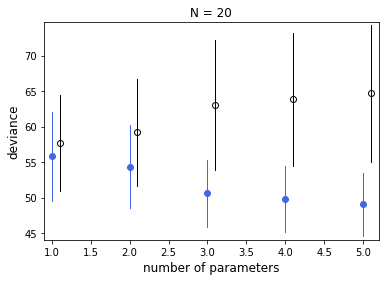

In [15]:
plt.plot(range(1, 6), dev[0].tolist(), "o", c="royalblue")
plt.xlim(1 - 0.1, 5.1 + 0.1)
plt.ylim(dev[:2].min() - 5, dev[:2].max() + 10)
plt.xlabel("number of parameters")
plt.ylabel("deviance")
plt.title("N = {}".format(N))
plt.plot([x + 0.1 for x in range(1, 6)], dev[1].tolist(), "ok", fillstyle="none")
for i in kseq:
    pts_int = dev[0, i - 1] + torch.tensor([-1., 1]) * dev[2, i - 1]
    pts_out = dev[1, i - 1] + torch.tensor([-1., 1]) * dev[3, i - 1]
    plt.plot([i, i], pts_int.tolist(), c="royalblue")
    plt.plot([i + 0.1, i + 0.1], pts_out.tolist(), c="k");

#### Code 6.15

In [16]:
cars = pd.read_csv("../data/cars.csv", sep=",")
cars_speed = torch.tensor(cars["speed"].values, dtype=torch.float)
cars_dist = torch.tensor(cars["dist"].values, dtype=torch.float)

def m_model(speed, distance):
    a = pyro.sample("a", dist.Normal(0, 100))
    b = pyro.sample("b", dist.Normal(0, 10))
    mu = a + b * speed
    sigma = pyro.sample("sigma", dist.Uniform(0, 30))
    pyro.sample("dist", dist.Normal(mu, sigma), obs=distance)

m = MAP("m", m_model, start="mean", speed=cars_speed, distance=cars_dist)
m.fit()
post = m.extract_samples(n=1000)

#### Code 6.16

In [17]:
def get_ll(s):
    mu = post["a"][s] + post["b"][s] * cars_speed
    return dist.Normal(mu, post["sigma"][s]).log_prob(cars_dist)

n_samples = 1000
ll = torch.stack([get_ll(s) for s in range(n_samples)], dim=1)

#### Code 6.17

In [20]:
n_cases = cars.shape[0]
lppd = ll.logsumexp(1) - math.log(n_samples)

#### Code 6.18

In [21]:
pWAIC = ll.var(1)

#### Code 6.19

In [22]:
-2 * (lppd.sum() - pWAIC.sum())

tensor(421.3170)

#### Code 6.20

In [23]:
waic_vec = -2 * (lppd - pWAIC)
(n_cases * waic_vec.var()).sqrt()

tensor(14.4520)

#### Code 6.21

In [24]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk.dropna().copy()
d.loc[:, "neocortex"] = d["neocortex.perc"] / 100
d_kcal_per_g = torch.tensor(d["kcal.per.g"].values, dtype=torch.float)
d_neocortex = torch.tensor(d["neocortex"].values, dtype=torch.float)
d_mass = torch.tensor(d["mass"].values, dtype=torch.float)
d.shape

(17, 9)

#### Code 6.22

In [25]:
a_start = d_kcal_per_g.mean()
sigma_start = d_kcal_per_g.std().log()

def m6_11_model(kcal_per_g):
    a = pyro.param("m6.11_a", a_start.clone())
    log_sigma = pyro.param("m6.11_log.sigma", sigma_start.clone())
    pyro.sample("kcal.per.g", dist.Normal(a, log_sigma.exp()), obs=kcal_per_g)

m6_11 = MAP("m6.11", m6_11_model, kcal_per_g=d_kcal_per_g)
m6_11.fit(lr=0.1, num_steps=300)

def m6_12_model(neocortex, kcal_per_g):
    a = pyro.param("m6.12_a", a_start.clone())
    bn = pyro.param("m6.12_bn", torch.tensor(0.))
    mu = a + bn * neocortex
    log_sigma = pyro.param("m6.12_log.sigma", sigma_start.clone())
    pyro.sample("kcal.per.g", dist.Normal(mu, log_sigma.exp()), obs=kcal_per_g)

m6_12 = MAP("m6.12", m6_12_model, neocortex=d_neocortex, kcal_per_g=d_kcal_per_g)
m6_12.fit(lr=0.1, num_steps=300)

def m6_13_model(log_mass, kcal_per_g):
    a = pyro.param("m6.13_a", a_start.clone())
    bm = pyro.param("m6.13_bm", torch.tensor(0.))
    mu = a + bm * log_mass
    log_sigma = pyro.param("m6.13_log.sigma", sigma_start.clone())
    pyro.sample("kcal.per.g", dist.Normal(mu, log_sigma.exp()), obs=kcal_per_g)

m6_13 = MAP("m6.13", m6_13_model, log_mass=d_mass.log(), kcal_per_g=d_kcal_per_g)
m6_13.fit(lr=0.1, num_steps=300)

def m6_14_model(neocortex, log_mass, kcal_per_g):
    a = pyro.param("m6.14_a", a_start.clone())
    bn = pyro.param("m6.14_bn", torch.tensor(0.))
    bm = pyro.param("m6.14_bm", torch.tensor(0.))
    mu = a + bn * neocortex + bm * log_mass
    log_sigma = pyro.param("m6.14_log.sigma", sigma_start.clone())
    pyro.sample("kcal.per.g", dist.Normal(mu, log_sigma.exp()), obs=kcal_per_g)

m6_14 = MAP("m6.14", m6_14_model, neocortex=d_neocortex,
            log_mass=d_mass.log(), kcal_per_g=d_kcal_per_g)
m6_14.fit(lr=0.1, num_steps=300);

#### Code 6.23

In [26]:
m6_14.WAIC()

{'WAIC': tensor(-14.8104),
 'lppd': tensor(12.3248),
 'pWAIC': tensor(4.9196),
 'se': tensor(8.0681)}

#### Code 6.24

In [27]:
milk_models = compare(m6_11, m6_12, m6_13, m6_14)
milk_models

,WAIC,pWAIC,dWAIC,weight,SE,dSE
m6.14,-14.545875,5.038521,0.000000,0.918659,7.979974,0.000000
m6.13,-8.039331,2.951427,6.506543,0.035504,5.802405,5.485536
m6.11,-7.923896,2.002622,6.621979,0.033513,4.888330,7.560323
m6.12,-5.923181,3.056408,8.622694,0.012324,4.438611,7.730103


#### Code 6.25

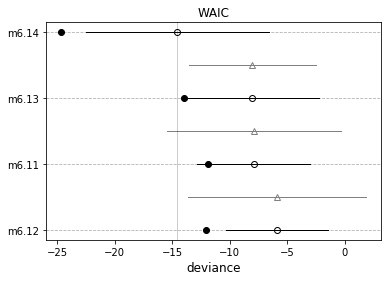

In [28]:
compare_plot(milk_models)

#### Code 6.26

In [29]:
diff = torch.empty(int(1e5)).normal_(6.7, 7.26)
(diff < 0).float().sum() / 1e5

tensor(0.1787)

#### Code 6.27

In [30]:
coeftab(False, m6_11, m6_12, m6_13, m6_14)

,m6.11,m6.12,m6.13,m6.14
a,0.66,0.36,0.71,-1.05
log.sigma,-1.79,-1.80,-1.85,-2.16
bn,NaN,0.44,NaN,2.74
bm,NaN,NaN,-0.03,-0.10
nobs,17.00,17.00,17.00,17.00


#### Code 6.28

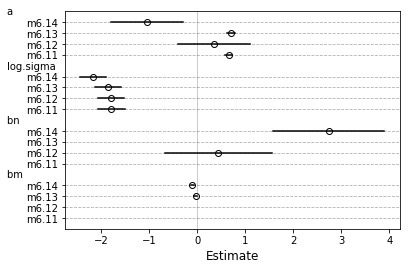

In [31]:
mean_df, lower_PI, upper_PI = coeftab(True, m6_11, m6_12, m6_13, m6_14)
pos = 1
ticks = []
labels = []
for coef in mean_df.index[:-1]:
    plt.plot(mean_df.loc[coef, ::-1], range(pos, pos + mean_df.shape[1]),
             "ko", fillstyle="none")
    ticks += list(range(pos, pos + mean_df.shape[1]))
    labels += mean_df.columns.tolist()[::-1]
    pos = pos + mean_df.shape[1] + 1
    for i, m in enumerate(lower_PI.columns):
        plt.plot([lower_PI.loc[coef, m], upper_PI.loc[coef, m]],
                 [pos - i - 2, pos - i - 2], c="k", lw=1.5)
coef_format = "{{:<{}}}".format(mean_df.index[:-1].map(len).max())
for i, coef in enumerate(mean_df.index[:-1]):
    plt.text(plt.xlim()[0] - 1.2, i * (mean_df.shape[1] + 1) + 0.3,
             coef_format.format(coef))
plt.yticks(ticks, labels)
plt.ylim(0, pos - 1)
plt.gca().invert_yaxis()
plt.axvline(x=0, c="k", alpha=0.2)
plt.grid(axis="y", linestyle="--")
plt.xlabel("Estimate");

#### Code 6.29

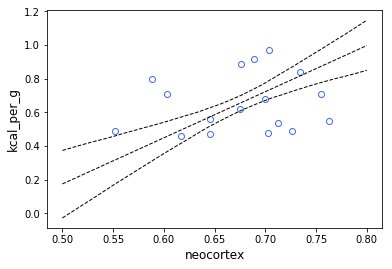

In [32]:
# compute counterfactual predictions
# neocortex from 0.5 to 0.8
nc_seq = torch.linspace(start=0.5, end=0.8, steps=30)
d_predict = {
    "kcal_per_g": torch.full((30,), 0),  # empty outcome
    "neocortex": nc_seq,  # sequence of neocortex
    "log_mass": torch.full((30,), 4.5).log()  # average mass
}
pred_m6_14 = m6_14.link(**d_predict)
mu = pred_m6_14.mean(0)
mu_PI = PI(pred_m6_14, dim=0)

# plot it all
fig, ax = plt.subplots()
ax.plot(d_neocortex.tolist(), d_kcal_per_g.tolist(), "o", c="royalblue", fillstyle="none")
ax.set_xlabel("neocortex")
ax.set_ylabel("kcal_per_g")
ax.plot(nc_seq.tolist(), mu.tolist(), "k--")
ax.plot(nc_seq.tolist(), mu_PI[0].tolist(), "k--")
ax.plot(nc_seq.tolist(), mu_PI[1].tolist(), "k--");

#### Code 6.30

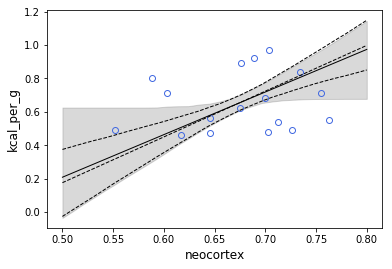

In [33]:
milk_ensemble = ensemble(d_predict, m6_11, m6_12, m6_13, m6_14)
mu = milk_ensemble["link"].mean(0)
mu_PI = PI(milk_ensemble["link"], dim=0)
ax.plot(nc_seq.tolist(), mu.tolist(), "k")
ax.fill_between(nc_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.15)
fig

#### Code 6.31

In [34]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d["age"] = (d["age"] - d["age"].mean()) / d["age"].std()
seed = 1000
i = pd.Series(range(d.shape[0])).sample(n=d.shape[0] // 2, random_state=seed)
d1 = d.iloc[i]
d2 = d.drop(index=i)